In [1]:
import os  # For interacting with the file system
import pandas as pd  # For handling dataframes and CSVs
import numpy as np
from elasticsearch import helpers, Elasticsearch
from datetime import datetime
from tqdm import tqdm  # Import tqdm for progress tracking

In [2]:
# Retrieve authentication information for Elasticsearch
elastic_host = "https://localhost"
elastic_port = "9200"
elastic_user = "admin"
elastic_password = "motdepasse"
elastic_ca_path = "C:\\elasticsearch-8.15.2\\config\\certs\\http_ca.crt"

# Connect to Elasticsearch
es = Elasticsearch(
     hosts=[f"{elastic_host}:{elastic_port}"],
     basic_auth=(elastic_user, elastic_password),
     ca_certs=elastic_ca_path,
     verify_certs=True
)
print(es.info())

# Check connection
if es.ping():
     print("Connected to Elasticsearch")
else:
     print("Failed to connect to Elasticsearch")

{'name': 'MSI', 'cluster_name': 'elasticsearch', 'cluster_uuid': 'ylmZI0lnRpa-pP1lwEKJ7A', 'version': {'number': '8.15.2', 'build_flavor': 'default', 'build_type': 'zip', 'build_hash': '98adf7bf6bb69b66ab95b761c9e5aadb0bb059a3', 'build_date': '2024-09-19T10:06:03.564235954Z', 'build_snapshot': False, 'lucene_version': '9.11.1', 'minimum_wire_compatibility_version': '7.17.0', 'minimum_index_compatibility_version': '7.0.0'}, 'tagline': 'You Know, for Search'}
Connected to Elasticsearch


In [3]:
def fetch_flows_from_elasticsearch(index_name):
     data = []
     
     # Define the body with a filter on application_name
     body = {
          "query": {
                "match_all": {}
          }
     }
     
     res = helpers.scan(
                          client=es,
                          scroll='2m',
                          query=body,
                          index=index_name)
     
     for i in res:
          data.append(i['_source'])
     
     # Converting into a Pandas dataframe
     df = pd.DataFrame(data)
     
     # Print the dataframe
     print(f"Network data : \n{df}")
     return df

In [4]:
df = fetch_flows_from_elasticsearch("network_flows_fan_encoded_final")

Network data : 
        application_name  bidirectional_packets  bidirectional_bytes  \
0                    NFS              -0.433819            -0.272394   
1                Unknown              -0.237225            -0.250029   
2                    DNS              -0.454513            -0.276022   
3                Unknown              -0.371737            -0.224462   
4                Unknown              -0.237225            -0.250029   
...                  ...                    ...                  ...   
1029442             HTTP              -0.371737            -0.220867   
1029443              NFS              -0.433819            -0.272394   
1029444              DNS              -0.454513            -0.275865   
1029445              DNS              -0.454513            -0.275865   
1029446          eDonkey              -0.133755            -0.178255   

         bidirectional_mean_ps  bidirectional_stddev_ps  src2dst_mean_ps  \
0                    -0.737396             

In [5]:
from sklearn.model_selection import train_test_split, StratifiedKFold

# Assuming 'application_name' is the target column in df_http for stratification
# Separate features and target
X = df.drop(columns=["label"])  # Features
y = df["label"]  # Target variable

# Step 1: Split data into 80% train and 20% test, with stratification
X_train, X_test, y_train, y_test = train_test_split(
     X, y, test_size=0.2, stratify=y, random_state=42
)

In [14]:
df["label"].value_counts()

label
0    1021443
1       8004
Name: count, dtype: int64

In [15]:
y_test.value_counts()

label
0    204289
1      1601
Name: count, dtype: int64

In [35]:
from sklearn.preprocessing import LabelEncoder
X_train['application_name'] = LabelEncoder().fit_transform(X_train['application_name'])
X_test['application_name'] = LabelEncoder().fit_transform(X_test['application_name'])

# Naive Bayes

In [36]:
train_subsets_NB = []

X_train_NB = X_train.astype(float)  # Convert boolean to float (or int) type
X_test_NB = X_test.astype(float)     # Same for X_test

X_train_NB = X_train_NB - X_train_NB.min()  # Shift all values to be positive
X_test_NB = X_test_NB - X_test_NB.min()  # Shift all values to be positive

In [37]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt


=== VALIDATION FINALE SUR L'ENSEMBLE DE TEST ===

Résultats sur l'ensemble de test:
Accuracy: 0.9910
Precision: 0.4627
Recall: 0.9463
F1-score: 0.6215
AUC-ROC: 0.9954

Rapport de classification détaillé:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00    204289
           1       0.46      0.95      0.62      1601

    accuracy                           0.99    205890
   macro avg       0.73      0.97      0.81    205890
weighted avg       1.00      0.99      0.99    205890



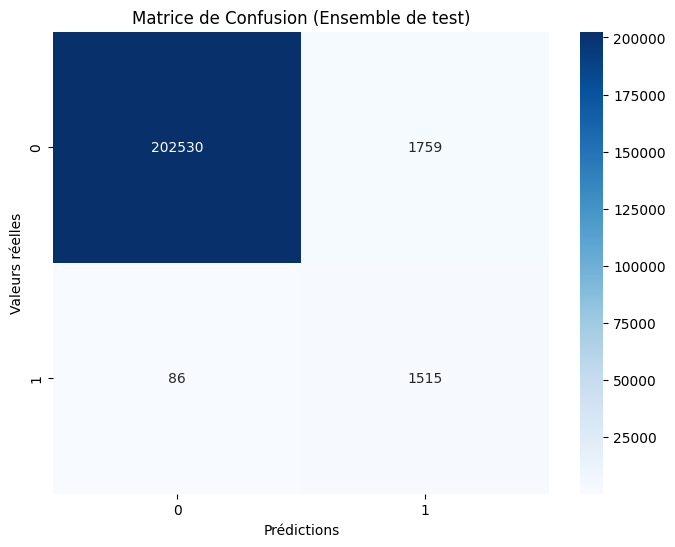

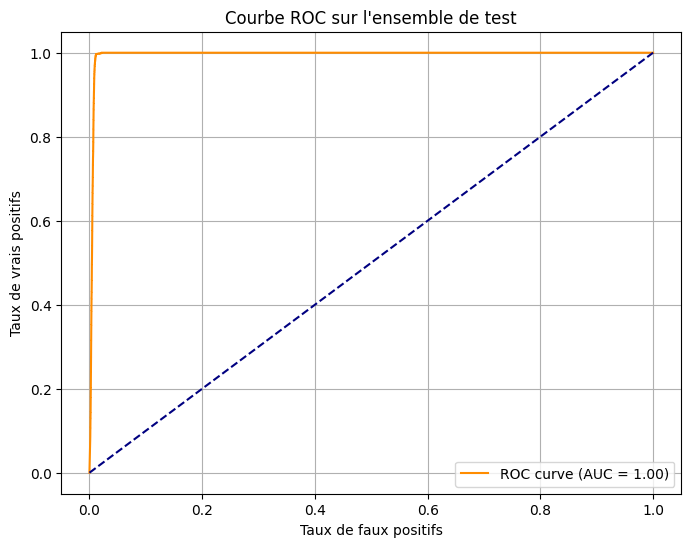

In [39]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# =============== VALIDATION FINALE ===============
print("\n=== VALIDATION FINALE SUR L'ENSEMBLE DE TEST ===")

# Initialiser le modèle Naive Bayes Multinomial avec le meilleur alpha
best_nb = MultinomialNB(alpha=1e-40)

# Entraîner le modèle
best_nb.fit(X_train_NB, y_train)

# Prédire sur l'ensemble de test
y_pred = best_nb.predict(X_test_NB)
y_pred_proba = best_nb.predict_proba(X_test_NB)

# Calculer les métriques d'évaluation
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label=1)
recall = recall_score(y_test, y_pred, pos_label=1)
f1 = f1_score(y_test, y_pred, pos_label=1)

# Calculer la courbe ROC et l'AUC pour l'ensemble de test
fpr_test, tpr_test, _ = roc_curve(y_test, y_pred_proba[:, 1])
roc_auc_test = auc(fpr_test, tpr_test)

# Afficher les résultats de validation
print(f"\nRésultats sur l'ensemble de test:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"AUC-ROC: {roc_auc_test:.4f}")

# Afficher le rapport de classification détaillé
print("\nRapport de classification détaillé:")
print(classification_report(y_test, y_pred))

# Créer et afficher la matrice de confusion
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matrice de Confusion (Ensemble de test)')
plt.xlabel('Prédictions')
plt.ylabel('Valeurs réelles')
plt.show()

# Tracer la courbe ROC finale sur l'ensemble de test
plt.figure(figsize=(8, 6))
plt.plot(fpr_test, tpr_test, color='darkorange',
            label=f'ROC curve (AUC = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbe ROC sur l\'ensemble de test')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

#### Observation : la précision baisse par rapport à une seule application cosidérée (+ de faux positifs). Le rappel reste élevé avec 94% de détection des intrusions.

# RandomForest

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Hyper parameters evaluation, code based on this site : https://medium.com/all-things-ai/in-depth-parameter-tuning-for-random-forest-d67bb7e920d

Evaluating with 64 n_estimators
Evaluating with 100 n_estimators
Evaluating with 150 n_estimators
Evaluating with 200 n_estimators


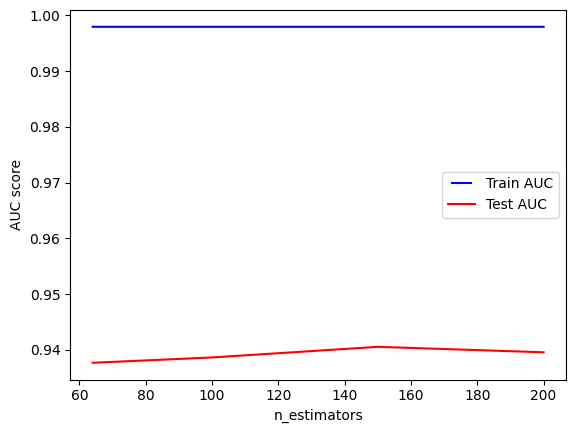

In [77]:
n_estimators = [64, 100, 150, 200]
train_results = []
test_results = []
for estimator in n_estimators:
    print(f'Evaluating with {estimator} n_estimators')
    rf = RandomForestClassifier(n_estimators=estimator, n_jobs=-1)
    rf.fit(X_train, y_train)
    train_pred = rf.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = rf.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)

from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(n_estimators, train_results, 'b', label="Train AUC")
line2, = plt.plot(n_estimators, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('n_estimators')
plt.show()

Evaluating with 1 max_depths
Evaluating with 2 max_depths
Evaluating with 3 max_depths
Evaluating with 4 max_depths
Evaluating with 5 max_depths
Evaluating with 6 max_depths
Evaluating with 7 max_depths
Evaluating with 8 max_depths
Evaluating with 9 max_depths
Evaluating with 10 max_depths


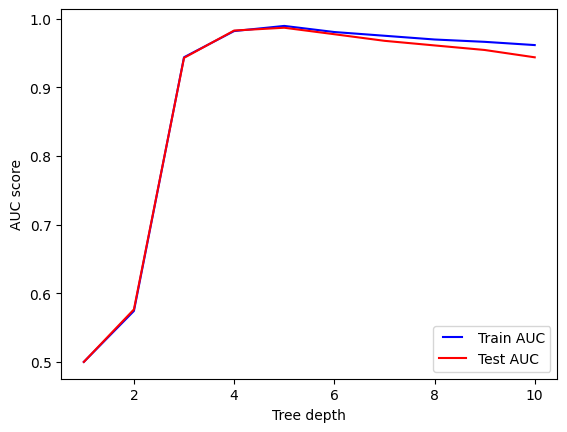

In [85]:
max_depths = np.linspace(1, 10, 10, endpoint=True)
train_results = []
test_results = []
for max_depth in max_depths:
    print(f'Evaluating with {int(max_depth)} max_depths')
    rf = RandomForestClassifier(max_depth=int(max_depth), n_jobs=-1)
    rf.fit(X_train, y_train)
    train_pred = rf.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = rf.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)

from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results, 'b', label="Train AUC")
line2, = plt.plot(max_depths, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('Tree depth')
plt.show()

Evaluating with 2 min_samples_splits
Evaluating with 4 min_samples_splits
Evaluating with 6 min_samples_splits
Evaluating with 8 min_samples_splits


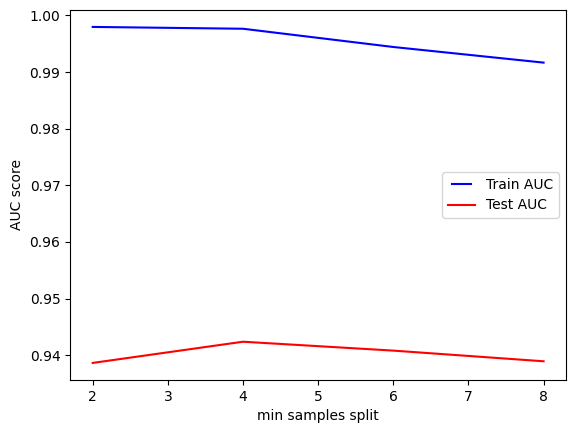

In [98]:
min_samples_splits = np.linspace(2, 8, 4, endpoint=True)
train_results = []
test_results = []
for min_samples_split in min_samples_splits:
   print(f'Evaluating with {int(min_samples_split)} min_samples_splits')
   rf = RandomForestClassifier(min_samples_split=int(min_samples_split))
   rf.fit(X_train, y_train)
   train_pred = rf.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = rf.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)

from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(min_samples_splits, train_results, 'b', label="Train AUC")
line2, = plt.plot(min_samples_splits, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('min samples split')
plt.show()

Evaluating with 1 min_samples_leafs
Evaluating with 2 min_samples_leafs
Evaluating with 3 min_samples_leafs
Evaluating with 4 min_samples_leafs


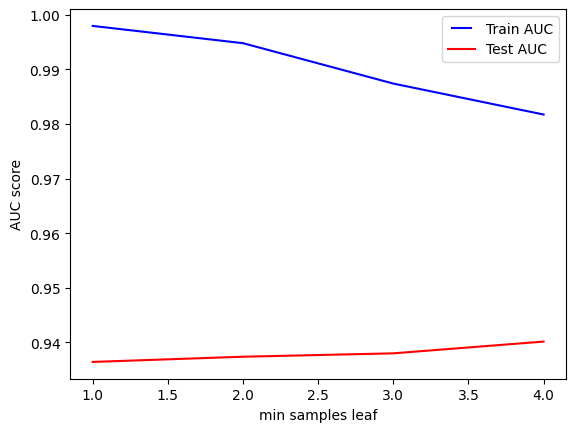

In [104]:
min_samples_leafs = list(range(1,5))
train_results = []
test_results = []
for min_samples_leaf in min_samples_leafs:
    print(f'Evaluating with {min_samples_leaf} min_samples_leafs')
    rf = RandomForestClassifier(min_samples_leaf=min_samples_leaf)
    rf.fit(X_train, y_train)
    train_pred = rf.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = rf.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)

from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(min_samples_leafs, train_results, 'b', label="Train AUC")
line2, = plt.plot(min_samples_leafs, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('min samples leaf')
plt.show()

Evaluating with 4 min_samples_leafs
Evaluating with 5 min_samples_leafs


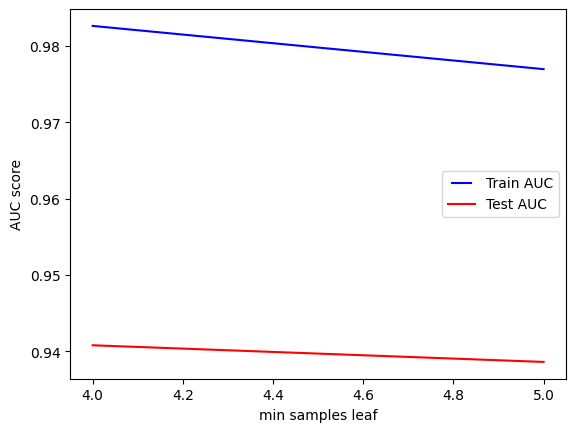

In [105]:
min_samples_leafs = list(range(4,6))
train_results = []
test_results = []
for min_samples_leaf in min_samples_leafs:
    print(f'Evaluating with {min_samples_leaf} min_samples_leafs')
    rf = RandomForestClassifier(min_samples_leaf=min_samples_leaf)
    rf.fit(X_train, y_train)
    train_pred = rf.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = rf.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)

from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(min_samples_leafs, train_results, 'b', label="Train AUC")
line2, = plt.plot(min_samples_leafs, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('min samples leaf')
plt.show()

Evaluating with 1 max_features
Evaluating with 11 max_features
Evaluating with 21 max_features
Evaluating with 31 max_features
Evaluating with 41 max_features
Evaluating with 51 max_features


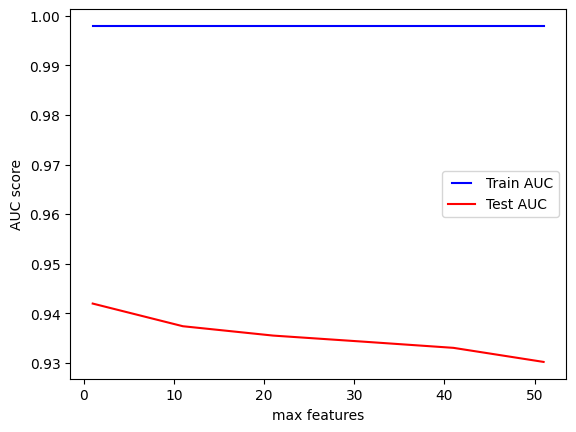

In [102]:
max_features = list(range(1,X_train.shape[1], 10))
train_results = []
test_results = []
for max_feature in max_features:
   print(f'Evaluating with {max_feature} max_features')
   rf = RandomForestClassifier(max_features=max_feature)
   rf.fit(X_train, y_train)
   train_pred = rf.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = rf.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)

from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_features, train_results, 'b', label="Train AUC")
line2, = plt.plot(max_features, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('max features')
plt.show()


=== VALIDATION FINALE SUR L'ENSEMBLE DE TEST AVEC LES MEILLEURS HYPER PARAMETRES ===

Résultats sur l'ensemble de test:
Accuracy: 0.9966
Precision: 0.6988
Recall: 0.9794
F1-score: 0.8156
AUC-ROC: 0.9992

Rapport de classification détaillé:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    204289
           1       0.70      0.98      0.82      1601

    accuracy                           1.00    205890
   macro avg       0.85      0.99      0.91    205890
weighted avg       1.00      1.00      1.00    205890



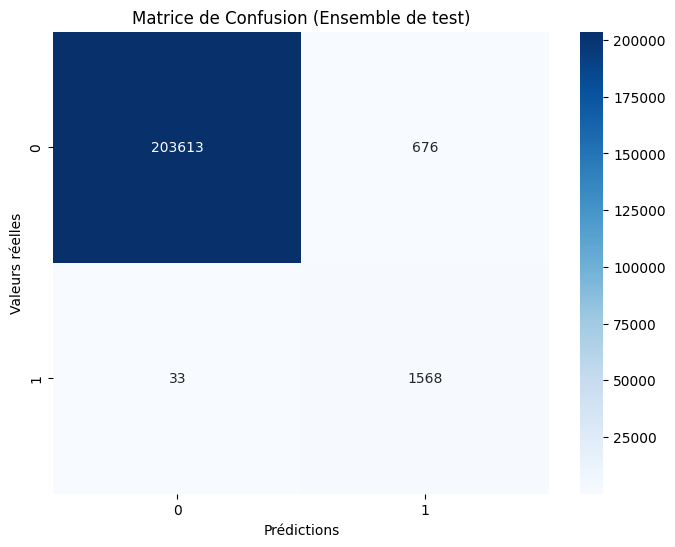

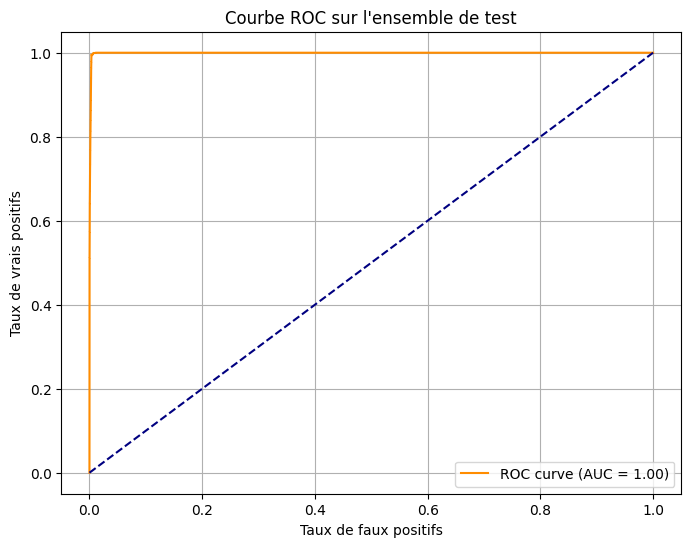

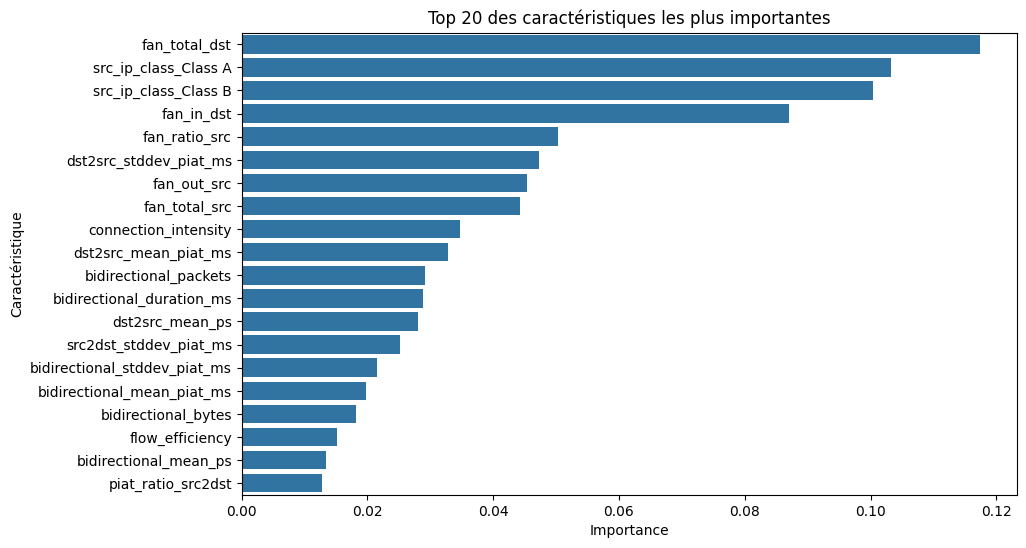

In [18]:
# =============== VALIDATION FINALE ===============
print("\n=== VALIDATION FINALE SUR L'ENSEMBLE DE TEST AVEC LES MEILLEURS HYPER PARAMETRES ===")

# Initialiser le modèle Random Forest avec le meilleur n_estimators
best_rf = RandomForestClassifier(
    n_estimators=150,
    random_state=42,
    max_depth=5,
    min_samples_split=4,
    min_samples_leaf=4,
    n_jobs=-1)

# Entraîner le modèle
best_rf.fit(X_train, y_train)

# Prédire sur l'ensemble de test
y_pred = best_rf.predict(X_test)
y_pred_proba = best_rf.predict_proba(X_test)

# Calculer les métriques d'évaluation
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label=1)
recall = recall_score(y_test, y_pred, pos_label=1)
f1 = f1_score(y_test, y_pred, pos_label=1)

# Calculer la courbe ROC et l'AUC pour l'ensemble de test
fpr_test, tpr_test, _ = roc_curve(y_test, y_pred_proba[:, 1])
roc_auc_test = auc(fpr_test, tpr_test)

# Afficher les résultats de validation
print(f"\nRésultats sur l'ensemble de test:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"AUC-ROC: {roc_auc_test:.4f}")

# Afficher le rapport de classification détaillé
print("\nRapport de classification détaillé:")
print(classification_report(y_test, y_pred))

# Créer et afficher la matrice de confusion
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matrice de Confusion (Ensemble de test)')
plt.xlabel('Prédictions')
plt.ylabel('Valeurs réelles')
plt.show()

# Tracer la courbe ROC finale sur l'ensemble de test
plt.figure(figsize=(8, 6))
plt.plot(fpr_test, tpr_test, color='darkorange',
            label=f'ROC curve (AUC = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbe ROC sur l\'ensemble de test')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Afficher l'importance des caractéristiques
feature_importance = pd.DataFrame({
     'feature': X_train.columns,
     'importance': best_rf.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance.head(20))
plt.title('Top 20 des caractéristiques les plus importantes')
plt.xlabel('Importance')
plt.ylabel('Caractéristique')
plt.show()

In [118]:
import joblib 

# save model with joblib 
filename = 'rfc_70_98_model.sav'
joblib.dump(best_rf, filename)

['rfc_70_98_model.sav']

## Validation croisée


=== Évaluation pour le 1e cinquième de données utilisé comme ensemble de test ===


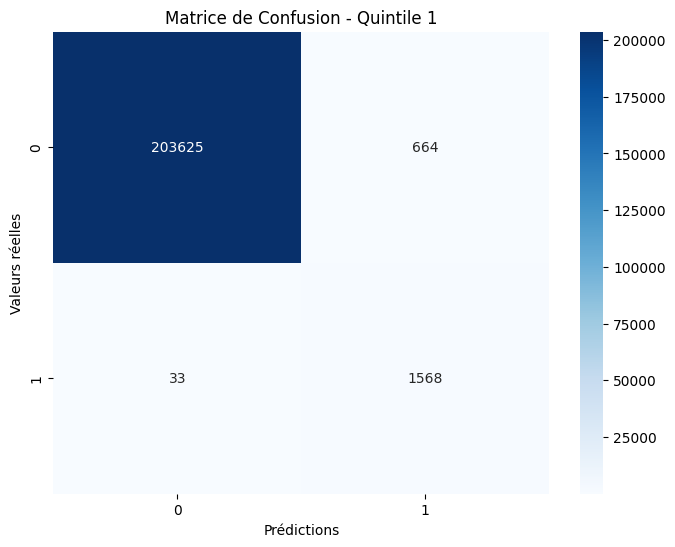

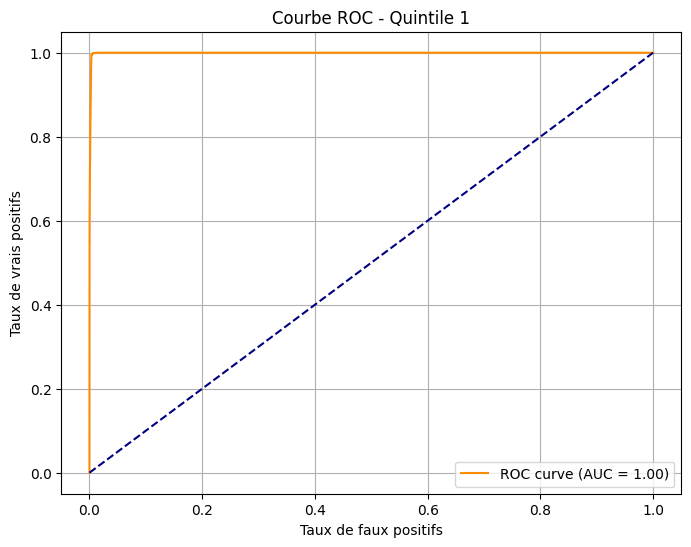


=== Évaluation pour le 2e cinquième de données utilisé comme ensemble de test ===


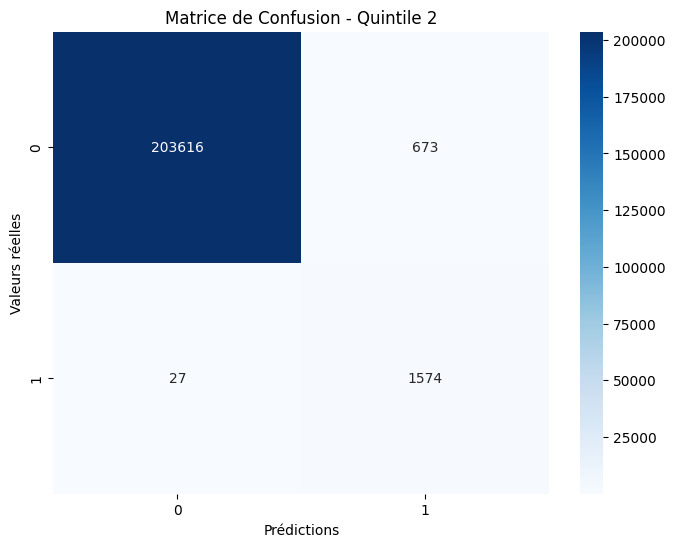

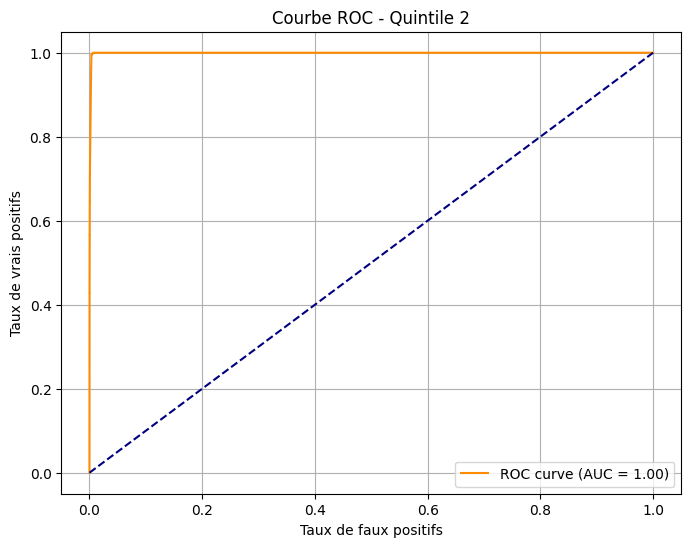


=== Évaluation pour le 3e cinquième de données utilisé comme ensemble de test ===


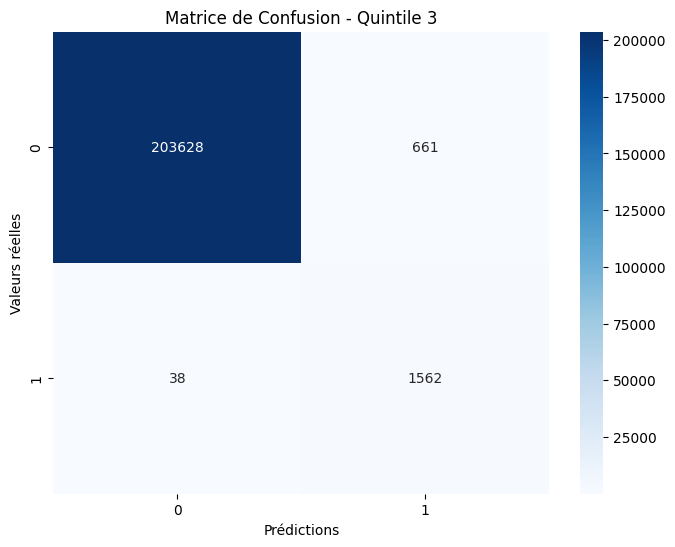

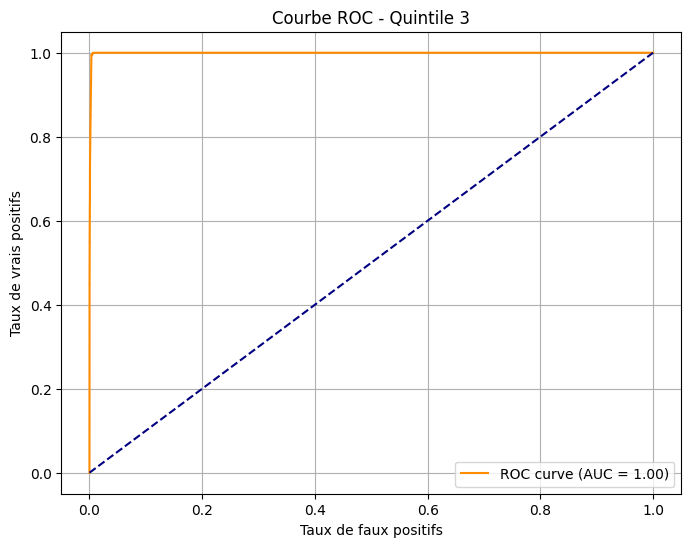


=== Évaluation pour le 4e cinquième de données utilisé comme ensemble de test ===


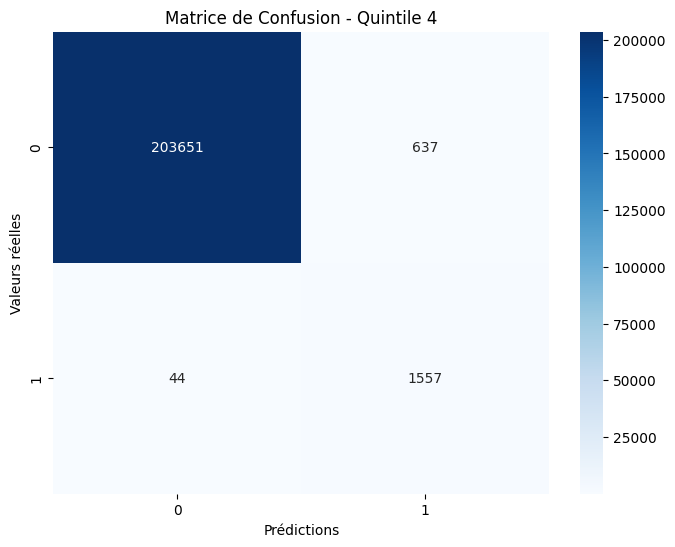

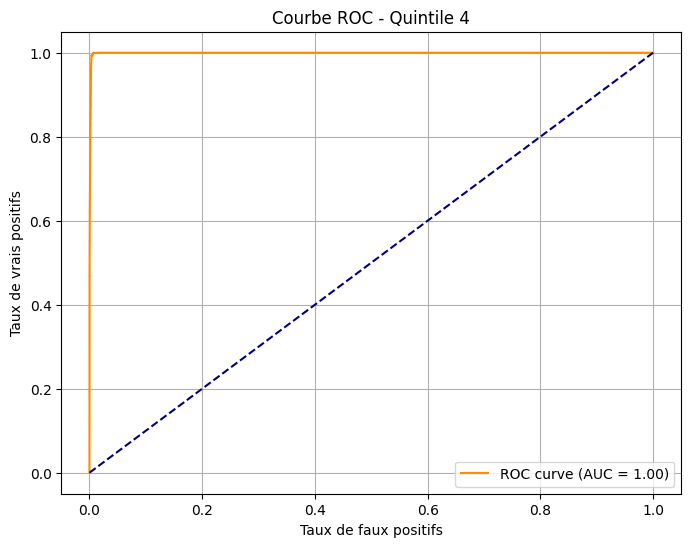


=== Évaluation pour le 5e cinquième de données utilisé comme ensemble de test ===


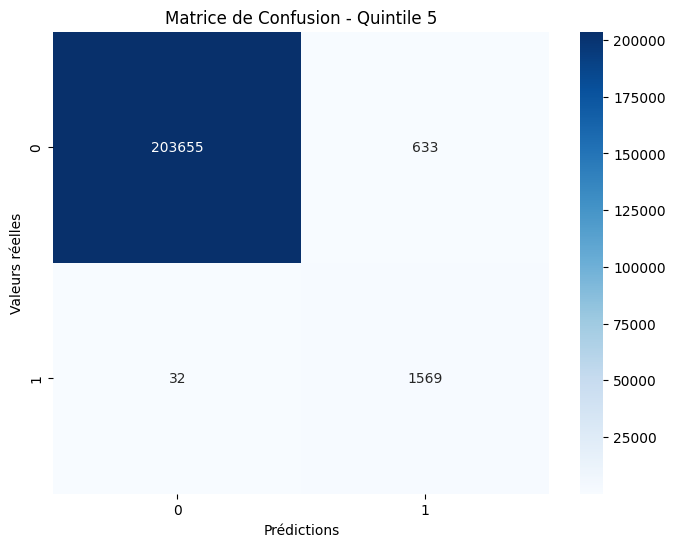

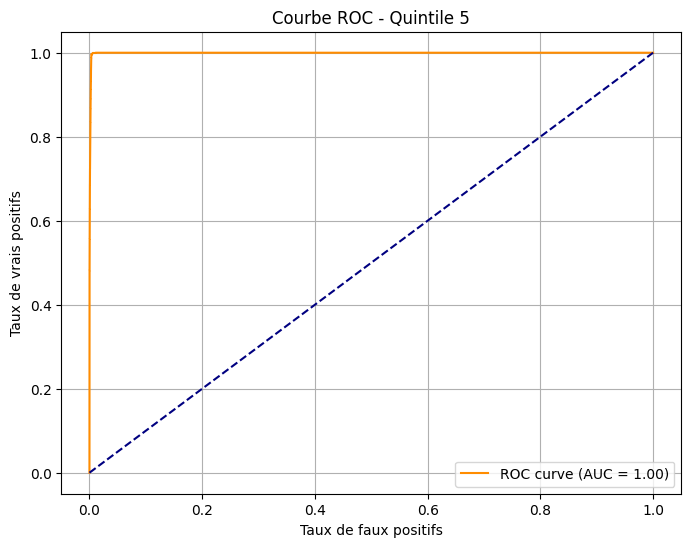


=== Résultats globaux ===
  Quintile  Accuracy  Precision    Recall  F1-Score   AUC-ROC
0   Part 1  0.996615   0.702509  0.979388  0.818158  0.999316
1   Part 2  0.996600   0.700490  0.983136  0.818087  0.999278
2   Part 3  0.996605   0.702654  0.976250  0.817159  0.999230
3   Part 4  0.996692   0.709663  0.972517  0.820553  0.999231
4   Part 5  0.996770   0.712534  0.980012  0.825138  0.999281


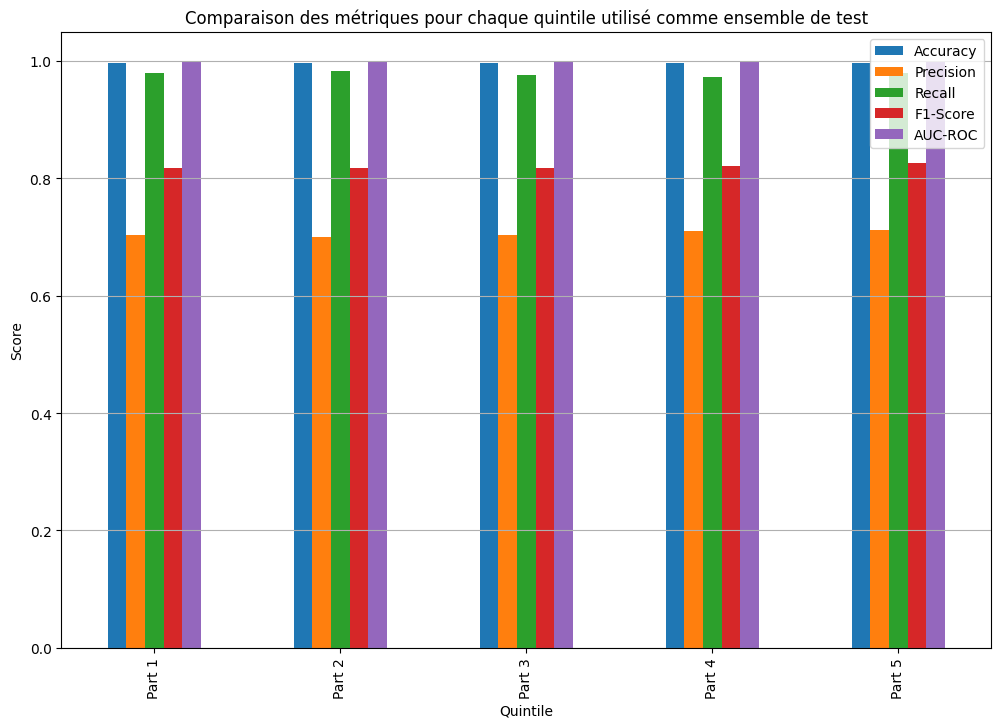

In [119]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_curve, auc, classification_report, confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Préparation des données
X = enriched_features.drop('label', axis=1, errors='ignore')
y = df['label'] if 'label' in df.columns else None

# Encode la colonne application_name si présente
if 'application_name' in X.columns:
    label_encoder = LabelEncoder()
    X['application_name'] = label_encoder.fit_transform(X['application_name'])

# Configuration du modèle
best_rf = RandomForestClassifier(
    n_estimators=150,
    random_state=42,
    max_depth=5,
    min_samples_split=4,
    min_samples_leaf=4,
    n_jobs=-1
)

# Validation croisée manuelle (5 partitions)
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
metrics = []

for i, (train_index, test_index) in enumerate(kf.split(X, y), start=1):
    print(f"\n=== Évaluation pour le {i}e cinquième de données utilisé comme ensemble de test ===")
    
    # Diviser les données
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Entraîner le modèle
    best_rf.fit(X_train, y_train)
    
    # Prédire
    y_pred = best_rf.predict(X_test)
    y_pred_proba = best_rf.predict_proba(X_test)
    
    # Calculer les métriques
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, pos_label=1)
    recall = recall_score(y_test, y_pred, pos_label=1)
    f1 = f1_score(y_test, y_pred, pos_label=1)
    fpr_test, tpr_test, _ = roc_curve(y_test, y_pred_proba[:, 1])
    roc_auc_test = auc(fpr_test, tpr_test)
    
    # Stocker les résultats
    metrics.append({
        'Quintile': f'Part {i}',
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'AUC-ROC': roc_auc_test
    })
    
    # Afficher la matrice de confusion
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Matrice de Confusion - Quintile {i}')
    plt.xlabel('Prédictions')
    plt.ylabel('Valeurs réelles')
    plt.show()
    
    # Tracer la courbe ROC
    plt.figure(figsize=(8, 6))
    plt.plot(fpr_test, tpr_test, color='darkorange', label=f'ROC curve (AUC = {roc_auc_test:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlabel('Taux de faux positifs')
    plt.ylabel('Taux de vrais positifs')
    plt.title(f'Courbe ROC - Quintile {i}')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

# Afficher les résultats globaux
metrics_df = pd.DataFrame(metrics)
print("\n=== Résultats globaux ===")
print(metrics_df)

# Visualiser les métriques pour chaque quintile
metrics_df.set_index('Quintile').plot(kind='bar', figsize=(12, 8))
plt.title('Comparaison des métriques pour chaque quintile utilisé comme ensemble de test')
plt.ylabel('Score')
plt.grid(axis='y')
plt.show()


In [121]:
import joblib 

# save model with joblib 
filename = 'rfc_71_98_model.sav'
joblib.dump(best_rf, filename)

['rfc_71_98_model.sav']


=== ANALYSE DES ERREURS PAR APPLICATION ===

Nombre total d'erreurs : 709
Nombre total de faux négatifs : 33


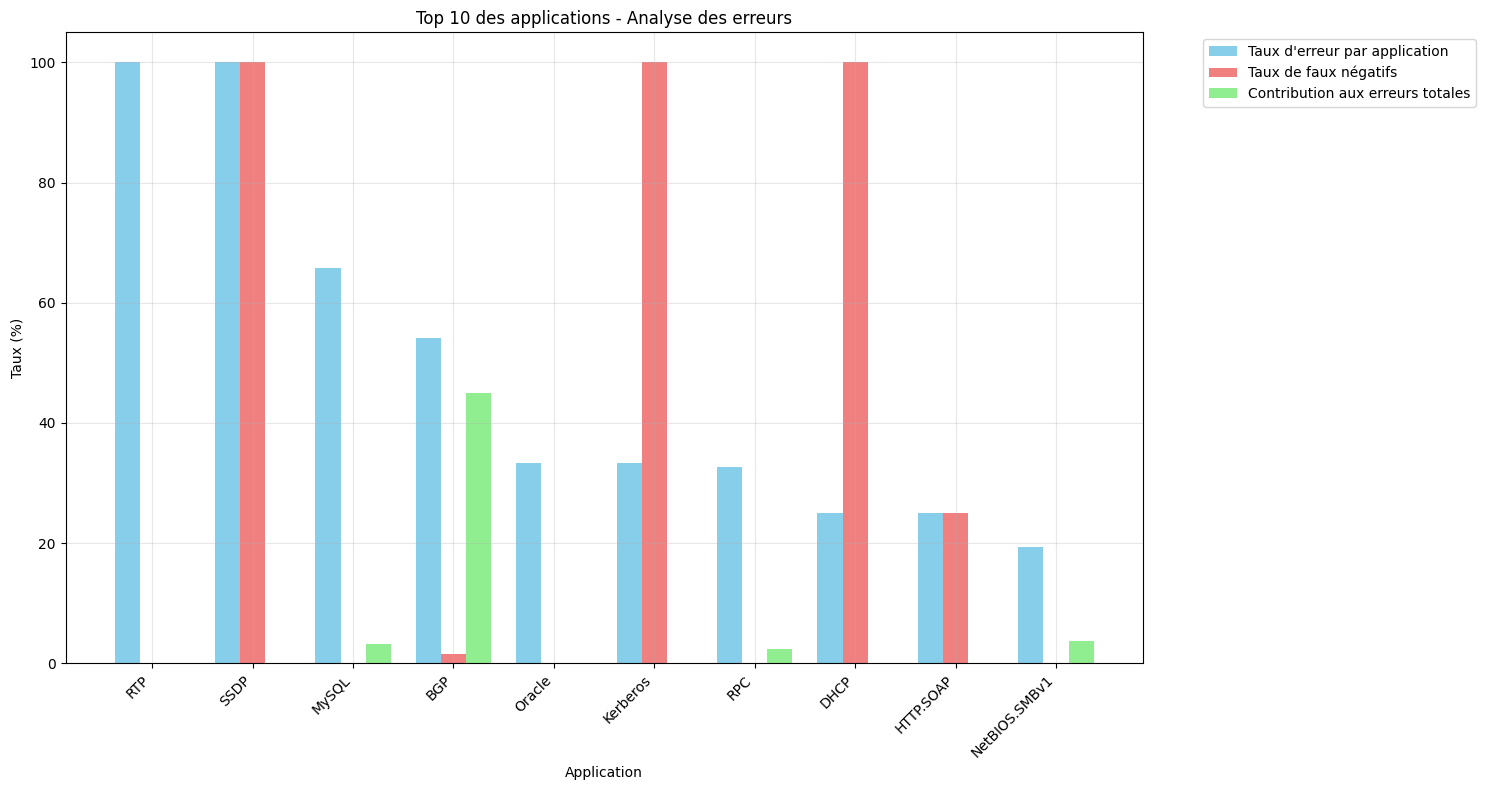


Top 10 des applications par taux d'erreur :
                  Total_Instances  Nombre_Erreurs  Taux_Erreur  \
application_name                                                 
SSDP                            1             1.0       100.00   
RTP                             1             1.0       100.00   
MySQL                          35            23.0        65.71   
BGP                           589           319.0        54.16   
Oracle                          3             1.0        33.33   
Kerberos                        3             1.0        33.33   
RPC                            52            17.0        32.69   
DHCP                            4             1.0        25.00   
HTTP.SOAP                       4             1.0        25.00   
NetBIOS.SMBv1                 139            27.0        19.42   

                  Nombre_Faux_Negatifs  Taux_Faux_Negatifs  \
application_name                                             
SSDP                               1.0

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def analyser_erreurs_par_application(y_test, y_pred, df_test, label_encoder):
    """
    Analyse détaillée des erreurs et faux négatifs par application avec noms originaux
    
    Parameters:
    -----------
    y_test : array-like
        Valeurs réelles
    y_pred : array-like
        Prédictions du modèle
    df_test : DataFrame
        DataFrame de test contenant la colonne 'application_name' encodée
    label_encoder : LabelEncoder
        L'encodeur utilisé pour transformer les noms d'applications
    """
    # Créer un DataFrame avec les prédictions et les vraies valeurs
    df_erreurs = pd.DataFrame({
        'vraie_valeur': y_test,
        'prediction': y_pred,
        'application_name': label_encoder.inverse_transform(df_test['application_name'])
    })
    
    # Ajouter une colonne pour identifier les erreurs
    df_erreurs['erreur'] = df_erreurs['prediction'] != df_erreurs['vraie_valeur']
    df_erreurs['faux_negatif'] = (df_erreurs['vraie_valeur'] == 1) & (df_erreurs['prediction'] == 0)
    
    # 1. Analyse globale des erreurs par application
    erreurs_par_app = df_erreurs[df_erreurs['erreur']].groupby('application_name').size()
    total_par_app = df_erreurs.groupby('application_name').size()
    taux_erreur_par_app = (erreurs_par_app / total_par_app * 100).sort_values(ascending=False)
    
    # 2. Analyse des faux négatifs par application
    faux_neg_par_app = df_erreurs[df_erreurs['faux_negatif']].groupby('application_name').size()
    positifs_par_app = df_erreurs[df_erreurs['vraie_valeur'] == 1].groupby('application_name').size()
    taux_faux_neg_par_app = (faux_neg_par_app / positifs_par_app * 100).sort_values(ascending=False)
    
    # 3. Calcul de la contribution aux erreurs totales
    total_erreurs = df_erreurs['erreur'].sum()
    contribution_erreurs = (erreurs_par_app / total_erreurs * 100).sort_values(ascending=False)
    
    # Affichage des résultats
    print("\n=== ANALYSE DES ERREURS PAR APPLICATION ===")
    print(f"\nNombre total d'erreurs : {total_erreurs}")
    print(f"Nombre total de faux négatifs : {df_erreurs['faux_negatif'].sum()}")
    
    # Création du DataFrame pour le graphique combiné
    df_plot = pd.DataFrame({
        'Taux d\'erreur': taux_erreur_par_app,
        'Taux de faux négatifs': taux_faux_neg_par_app,
        'Contribution aux erreurs totales': contribution_erreurs
    }).fillna(0)
    
    # Sélection des top N applications basé sur le taux d'erreur total
    N = 10
    top_apps = df_plot['Taux d\'erreur'].sort_values(ascending=False).head(N).index
    df_plot_top = df_plot.loc[top_apps]
    
    # Création du graphique combiné
    plt.figure(figsize=(15, 8))
    X = np.arange(len(df_plot_top.index))
    width = 0.25  # Réduit pour accommoder 3 barres
    
    plt.bar(X - width, df_plot_top['Taux d\'erreur'], width, 
            label='Taux d\'erreur par application', color='skyblue')
    plt.bar(X, df_plot_top['Taux de faux négatifs'], width,
            label='Taux de faux négatifs', color='lightcoral')
    plt.bar(X + width, df_plot_top['Contribution aux erreurs totales'], width,
            label='Contribution aux erreurs totales', color='lightgreen')
    
    plt.title('Top 10 des applications - Analyse des erreurs')
    plt.xlabel('Application')
    plt.ylabel('Taux (%)')
    plt.xticks(X, df_plot_top.index, rotation=45, ha='right')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Créer un DataFrame de résumé
    resume = pd.DataFrame({
        'Total_Instances': total_par_app,
        'Nombre_Erreurs': erreurs_par_app,
        'Taux_Erreur': taux_erreur_par_app,
        'Nombre_Faux_Negatifs': faux_neg_par_app,
        'Taux_Faux_Negatifs': taux_faux_neg_par_app,
        'Contribution_Erreurs_Totales': contribution_erreurs
    }).round(2)
    
    print("\nTop 10 des applications par taux d'erreur :")
    print(resume.sort_values('Taux_Erreur', ascending=False).head(10))
    
    print("\nTop 10 des applications par taux de faux négatifs :")
    print(resume.sort_values('Taux_Faux_Negatifs', ascending=False).head(10))
    
    print("\nTop 10 des applications par contribution aux erreurs totales :")
    print(resume.sort_values('Contribution_Erreurs_Totales', ascending=False).head(10))
    
    return resume

# Exemple d'utilisation:
resume_erreurs = analyser_erreurs_par_application(y_test, y_pred, X_test, label_encoder)